# Job Timing Study
This notebook is for studying the behavior of jobs using the new condor installation on the new cluster.

### Goals
- Determine a good user configuration of job clusters
- Understand condor configuration variables

The condor configuration variables that configure file transfer are listed below. Their names and descriptions are simply copied from the [documentation](https://htcondor.readthedocs.io/en/latest/admin-manual/configuration-macros.html#condor-master-configuration-file-macros).

- `MAX_CONCURRENT_DOWNLOADS` : absolute max of simultaneous transfers of output files from execute machines to submit machine
- `MAX_CONCURRENT_UPLOADS` : absolute max of simultaneous transfers of input files from submit machine to execute machines
- `FILE_TRANSFER_DISK_LOAD_THROTTLE` : disk load triggering throttling
    - disk load is calculated as the average number of simultaneous read/write operations (the averaging time is specified by other parameters that we avoid modifying)
    - throttling dynamically decreases the allowed number of concurrent uploads and downloads
    - two parameters defined: upper and lower limit. When disk load is above upper limit, no new transfers can be started. When disk load is between, new transfers are only started to replace completed ones. When below lower limit, transfers up to absolute maxima are allowed

### Requirements
- htcondor : Python API for interacting with HTCondor
- Run on spa-osg-login (or whereever jobs are submitted from) so we can acquire the job history
- pandas and matplotlib for data visualization and analysis

### HTCondor Explanatory Comma
HTCondor stores job data in "ClassAd" expressions stored in the job "spool" on the submit machine. We can use HTCondor's API to extract information from this data. The variables we use for timing information are listed below. All times used here are given in seconds since the Unix epoch.

Variable | Description
---|---
ClusterId | ID number for cluster of jobs
ProcId | ID number of process within a cluster
ExitCode | code returned by process ran within job
TransferInputSizeMB | size of all input files that need to be copied to execute directory
JobStartDate | time job was started i.e. it has a slot allocated to it and can begin transferring or executing
Transfer{In,Out}Queued | time job was put into transfer in/out queue (may be undefined if job was never queued)
Transfer{In,Out}Started | time job's input/output files actually started to transfer in/out
TransferInFinished | time job's input files completed transfer and it can begin executing
TransferOutFinished | time job's output files completed, treated as effective job end time

**WARNING**: This notebook alone is not reproducible into the future. HTCondor prunes its job history periodically so that it doesn't fill up the disk. This means in order to reproduce these results, you will need to rerun your own clusters of jobs matching the criteria described below. Even then, if you are using different input files, then the data itself will not perfectly align.

In [42]:
import htcondor
import classad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def acquire_timing(constraint) :
    """Acquire timing data from jobs matching the input constraint
    
    A constraint is following HTCondor's classad API. For example,
    a simple constraint would be matching a specific cluster ID from
    the past.
    
        classad.Attribute('ClusterId') == 420
        
    After acquiring the raw timing data from the condor schedd,
    we add a few more columns to the data frame with variables of interest.
    
    - 'JobTime' : difference between output transfer complete and job start
        (not perfectly equal to total job time but within a few seconds)
    - 'Transfer{In,Out}' : time [s] spent actually copying data in/out
    - 'FracTransfer{In,Out}' : fraction of job time spent copying data in/out
    - 'Trasnfer{In,Out}QueueTime' : time [s] job spent in queue to copy data in/out
    """
    
    items_of_interest = {
        'ClusterId' : [],
        'ProcId' : [],
        'ExitCode' : [],
        'QDate' : [],
        'TransferInputSizeMB' : [],
        'JobStartDate' : [],
        'TransferInQueued' : [],
        'TransferInStarted' : [],
        'TransferInFinished' : [],
        'TransferOutQueued' : [],
        'TransferOutStarted' : [],
        'TransferOutFinished' : []
    }
    schedd = htcondor.Schedd()
    if isinstance(constraint,int) :
        # assume constraint is just a cluster id
        constraint = (classad.Attribute('ClusterId') == constraint)
    for h in schedd.history(constraint,list(items_of_interest.keys())) :
        for k in items_of_interest :
            items_of_interest[k].append(h.get(k))

    df = pd.DataFrame(items_of_interest)
    df['JobTime'] = df['TransferOutFinished']-df['JobStartDate']
    for d in ['In','Out'] :
        df[f'Transfer{d}'] = df[f'Transfer{d}Finished'] - df[f'Transfer{d}Started'] 
        df[f'Transfer{d}QueueTime'] = (df[f'Transfer{d}Started']-df[f'Transfer{d}Queued']).fillna(0)
    df['ExecuteTime'] = df['JobTime']-df['TransferIn']-df['TransferOut']
    return df

def plot_timing(constraint) :
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(figsize=(10, 8))

    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)
    ax_text = plt.axes([left+width+spacing,bottom+height+spacing,0.2,0.2])
    ax_text.axis('off')
    
    df = acquire_timing(constraint)
    
    cluster_time = (df['TransferOutFinished'].max() - df['QDate'].min())/60
    mean_job_time = df['JobTime'].mean()
    tot_execute = df['ExecuteTime'].sum()
    lines = [
        f'Total Submit to Complete: {cluster_time:.2f} min',
        f'Mean Job Time: {mean_job_time:.2f} s',
        f'Total Execute: {tot_execute} s',
        f'Eff N cores: {tot_execute/(cluster_time*60):.2f}'
    ]
    ax_text.text(0.01,0.01,'\n'.join(lines),verticalalignment='bottom',horizontalalignment='left')

    # the scatter plot:
    for d in ['In','Out'] :
        ax_scatter.scatter(df['ExecuteTime'], df[f'Transfer{d}'], label=d)

    # separate so we can get scatter limits for histogram
    for d in ['In','Out'] :
        ax_histy.hist(df[f'Transfer{d}'],bins=50, range=ax_scatter.get_ylim(),
                      label=d, orientation='horizontal', histtype='step')

    ax_scatter.set_xlabel('Execution Time [s]')
    ax_scatter.set_ylabel('Transfer Time [s]')
    ax_scatter.axline((0,0),slope=0.1,label='10% Transfer',color='black')
    ax_scatter.axline((0,0),slope=0.01,label='1% Transfer', color='gray')
    ax_scatter.legend()

    ax_histx.hist(df['ExecuteTime'], range=ax_scatter.get_xlim(), bins=50,
                  histtype='step', color='black', label='Execution Time')
    ax_histx.legend()
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histx.set_ylabel('Jobs')
    ax_histx.set_yscale('log')

    ax_histy.set_ylim(ax_scatter.get_ylim())
    ax_histy.set_xscale('log')
    ax_histy.set_xlabel('Jobs')

    plt.show()

## Default Configuration
I needed to re-run decoding for the LDMX testbeam data anyways and this offered a good opportunity to study how condor handles jobs that are of varying input size and time length. Additionally, the file transfer configuration has not been modified at this time, meaning we have the following settings (copying from the docs).

Macro  | Value
---|---
MAX_CONCURRENT_DOWNLOADS | 100
MAX_CONCURRENT_UPLOADS | 100
FILE_TRANSFER_DISK_LOAD_THROTTLE | 2.0

Now lets see the behavior of this condor configuration with various different running modes.

### Copy All Inputs
All inputs -- including the container image file (~1.6GB) and the configuration script -- are copied to the executing sandbox directory.
The input data file is on `/local/` but hte image file and config script are copied from the scratch on `spa-osg-login`.
The output files are writen to the scratch directory on `spa-osg-login` from which condor_submit was executed.

For reference, the submit file is copied below. It was run alongside the image and config listed.
```
executable = /usr/bin/singularity
transfer_executable = no

on_exit_hold = ExitCode != 0
on_exit_hold_subcode = ExitCode

arguments = "run --no-home --cleanenv --bind .:/work $BASENAME(image) /work fire $BASENAME(config) $BASENAME(input_file)"

image = tomeichlersmith_ldmx-sw_decoder.sif
config = decode_cfg.py

logfile_stub = $BASENAME(input_file)-$(Cluster)-$(Process)

output = $(logfile_stub).out
error  = $(output)
log    = $(logfile_stub).log

should_transfer_files = yes
transfer_input_files = $(input_file),$(image),$(config)
when_to_transfer_output = ON_EXIT

queue input_file matching files /local/cms/user/eichl008/ldmx/testbeam/unaligned/reformat/*
```

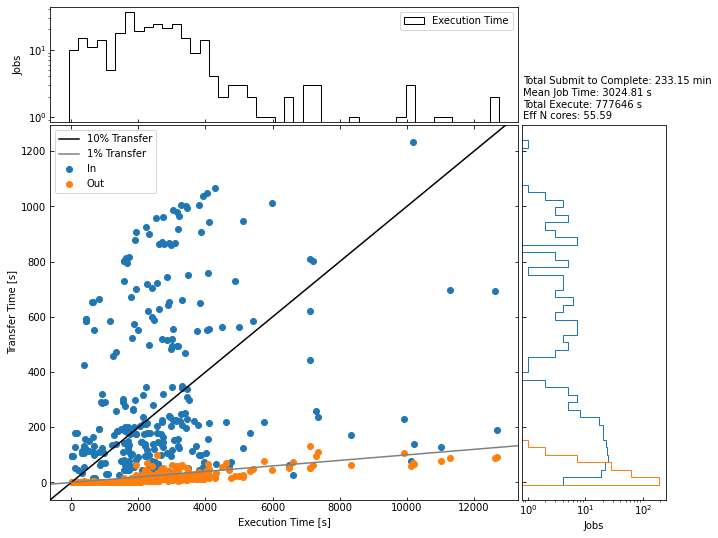

In [43]:
plot_timing(38)

### Don't Copy Container Image
Ran a cluster of jobs where the image is left on `/local/` to be read by jobs directly.
This is done by using the same submission file as before but changing the `transfer_input_files` to only be `$(input_file),$(config)` and specifying a full path to the image and config script on local. The output directory is still the scratch space on the login node.

```
executable = /usr/bin/singularity
transfer_executable = no

on_exit_hold = ExitCode != 0
on_exit_hold_subcode = ExitCode

arguments = "run --no-home --cleanenv --bind .:/work $(image) /work fire $BASENAME(config) $BASENAME(input_file)"

local = /local/cms/user/eichl008/ldmx

image = $(local)/tomeichlersmith_ldmx-sw_decoder.sif
config = $(local)/decode_cfg.py

logfile_stub = $BASENAME(input_file)-$(Cluster)-$(Process)

output = $(logfile_stub).out
error  = $(output)
log    = $(logfile_stub).log

should_transfer_files = yes
transfer_input_files = $(input_file),$(config)
when_to_transfer_output = ON_EXIT

queue input_file matching files /local/cms/user/eichl008/ldmx/testbeam/unaligned/reformat/*
```

Notice that no job-start throttling is implemented. This is because the throttling of input file transfers naturally also staggers the time each job reads from `/local/` to load the container image. Some slow-down with local were observed during this cluster - only observed by folks with high I/O rate programs running on local. We may wish to enforce a minimum job-start in case the input files a user is looping over are small enough.

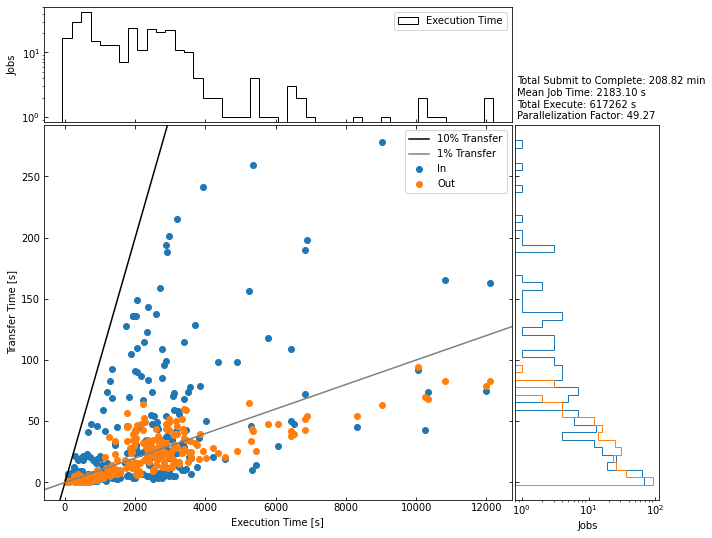

In [38]:
plot_timing(41)

### Michael's Test Analysis
In order to get someone with CMSSW experience on the new cluster, I asked Michael to try running his dark photon search analysis on the new cluster.
I haven't studied how he has done this in detail, but he is definitely copying the input files to scratch before running and leaving the CMSSW software directory as well as other intialization files on `/local/cms/...`. With this configuration, we see the jobs stay below this arbitrary 10% transfer threshold.

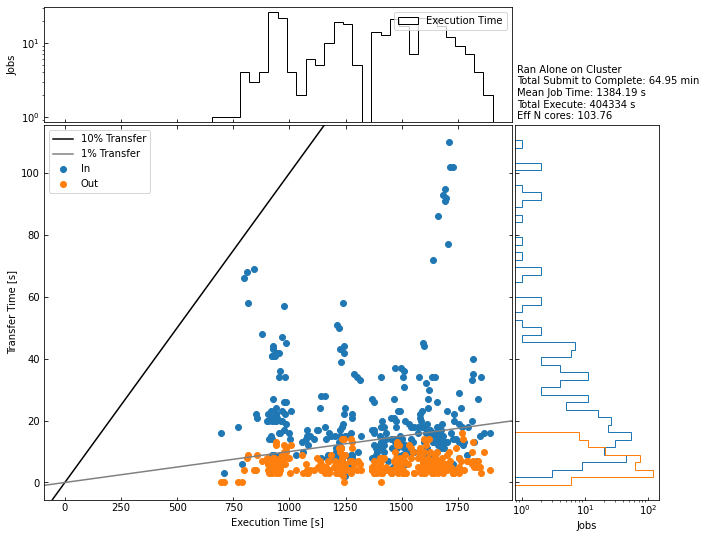

In [100]:
plot_timing(114,comments=['Ran Alone on Cluster'])

### Mohammad's Analysis
Mohammad does a very quick skim over large data files as part of his analysis. This is another useful test case to study the behavior of the cluster. I have gathered data on how this analysis runs both on the old cluster where the data files are on `/hdfs/cms/...` and will run the same analysis but with the data on `/local/cms/...` using the new cluster.

In [86]:
# read in data, dropping first 35 clusters which were test jobs
old = pd.read_csv('wadud/condor_history_wadud_scorpion1.log',delim_whitespace=True).drop(columns=['ProcId']).sort_values('ClusterId').set_index('ClusterId').reset_index().iloc[35:,:]
# drop jobs that didn't complete
old = old[old['CompletionDate']>0]
# calculate job time
old['ExecuteTime'] = pd.to_numeric(old['CompletionDate'])-pd.to_numeric(old['JobStartDate'])

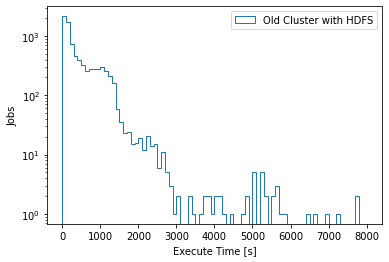

In [92]:
plt.hist(old['ExecuteTime'],histtype='step',range=(0,8000),bins=80,label='Old Cluster with HDFS')
plt.yscale('log')
plt.ylabel('Jobs')
plt.xlabel('Execute Time [s]')
plt.legend()
plt.show()